# Анализ поведения пользователей в приложении по продаже продуктов питания

**Описание проекта**

Получены данные о стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.

Необходимо изучить воронку продаж.
Узнайть, как пользователи доходят до покупки.
Узнать сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. На каких именно?

После этого исследуем результаты A/A/B-эксперимента. (Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста.)
Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

*Для выполнения проекта необходимо*: 
    
**Шаг 1**. Изучить общую информацию в файле /datasets/logs_exp.csv. 

**Шаг 2**. Подготовить данные
- Заменить названия столбцов;
- Проверить пропуски и типы данных;
- Добавить столбец даты и времени, а также отдельный столбец дат;

**Шаг 3**. Изучить и проверить данные:

Сколько всего событий в логе?

Сколько всего пользователей в логе?

Сколько в среднем событий приходится на пользователя?

Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. 

Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. 

Можно ли быть уверенным, что у нас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Необходимо определить, с какого момента данные полные и отбросьте более старые. 

Данными за какой период времени мы располагаем на самом деле?

Много ли событий и пользователей мы потеряли, отбросив старые данные?

Необходимо проверить, что у нас есть пользователи из всех трёх экспериментальных групп.

**Шаг 4**. Изучить воронку событий
Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие.

Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? 

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.

На каком шаге теряете больше всего пользователей?

Какая доля пользователей доходит от первого события до оплаты?

**Шаг 5**. Изучить результаты эксперимента

Сколько пользователей в каждой экспериментальной группе?

Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Необходимо проверить, находят ли статистические критерии разницу между выборками 246 и 247.

Необходимо выбрать самое популярное событие. 

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. 

Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). 

Можно ли сказать, что разбиение на группы работает корректно?

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. 

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие. 

EventName — название события;

DeviceIDHash — уникальный идентификатор пользователя;

EventTimestamp — время события;

ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Загрузка данных и подготовка их к анализу

In [2]:
import pandas as pd
import scipy.stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math 


In [3]:
logs_exp = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

In [4]:
logs_exp.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Приведем наименования столбцов в соответствии с правилами

In [5]:
logs_exp = logs_exp.rename(columns={'EventName': 'event_name', 'DeviceIDHash': 'device_id_hash',\
                                    'EventTimestamp':  'event_time_stamp', 'ExpId': 'exp_id'})

In [6]:
logs_exp.head()

,event_name,device_id_hash,event_time_stamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим тип данных

In [7]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   event_name        244126 non-null  object
 1   device_id_hash    244126 non-null  int64 
 2   event_time_stamp  244126 non-null  int64 
 3   exp_id            244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Мне кажется, что в колонке  event_time_stamp должен стоять тип данных даты, но при его изменении не получилось добавить колонки с датой и временем, поэтому оставлю так, как есть.

Проверим наличие пропусков

In [8]:
logs_exp.isna().sum()

event_name          0
device_id_hash      0
event_time_stamp    0
exp_id              0
dtype: int64

Пропуски отсутствуют

Проверим на наличие явных дубликатов

In [9]:
logs_exp.duplicated().sum()

413

In [10]:
logs_exp = logs_exp.drop_duplicates().reset_index(drop=True) 

In [11]:
logs_exp.duplicated().sum()

0

Добавим столбец даты и времени, а также отдельный столбец дат

In [12]:
logs_exp['date_time'] = pd.to_datetime(logs_exp['event_time_stamp'], unit='s') 
logs_exp['date'] = logs_exp['date_time'].dt.date
logs_exp['date'] = pd.to_datetime(logs_exp['date'])

In [13]:
logs_exp.head()

,event_name,device_id_hash,event_time_stamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [14]:
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        243713 non-null  object        
 1   device_id_hash    243713 non-null  int64         
 2   event_time_stamp  243713 non-null  int64         
 3   exp_id            243713 non-null  int64         
 4   date_time         243713 non-null  datetime64[ns]
 5   date              243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


In [15]:
logs_exp.head()

,event_name,device_id_hash,event_time_stamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Итак, в ходе подготовки данных к анализу, заменены наименования столбцов в соответствии с правилами, проверен тип данных, удалены дубликаты, пропускив датафрейме отсуствуют, а также добавлен столбец даты и времени, а также отдельный столбец дат.

## Изучим и проверим данные

**Сколько всего событий в логе?**

In [16]:
logs_exp['event_name'].value_counts().sum() 

243713

In [17]:
logs_exp['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

Общее количество событий 243713, наибольшее количество у MainScreenAppear (49%), наименьшее у Tutorial (4%).

**Сколько всего пользователей в логе?**

In [18]:
print('Общее количество пользователей:',len(logs_exp['device_id_hash'].unique()))

Общее количество пользователей: 7551


**Сколько в среднем событий приходится на пользователя?**

In [19]:
event_user = round(logs_exp['event_name'].value_counts().sum() / (len(logs_exp['device_id_hash'].unique())), 2)

In [20]:
print('Среднее число событий, приходящихся на одного пользователя', event_user)

Среднее число событий, приходящихся на одного пользователя 32.28


In [21]:
logs_exp.describe()

,device_id_hash,event_time_stamp,exp_id
count,2.437130e+05,2.437130e+05,243713.000000
mean,4.627963e+18,1.564914e+09,247.022161
std,2.642723e+18,1.771388e+05,0.824420
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


Все пользователи совершают примерно одинаковое количество событий

**Максимальная и минимальная дата события**

In [22]:
print('Максимальная дата события:', logs_exp['date'].min())
      
print('Минимальная дата события:', logs_exp['date'].max())

Максимальная дата события: 2019-07-25 00:00:00
Минимальная дата события: 2019-08-07 00:00:00


Данными за какой период мы располагаем?

In [23]:
print('Период исследуемых данных',logs_exp['date_time'].max()-logs_exp['date_time'].min())

Период исследуемых данных 13 days 16:31:41


Построим гистограмму по дате и количетсву событий

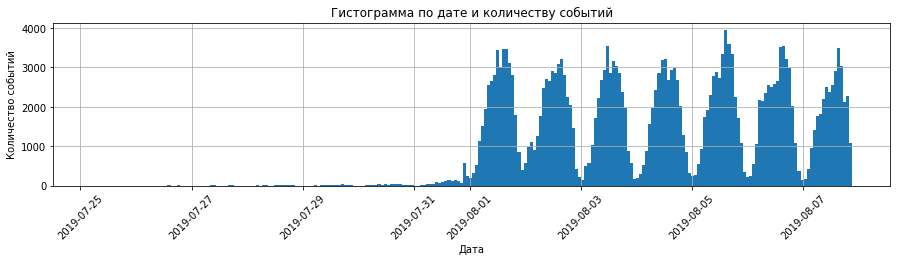

In [24]:
logs_exp['date_time'].hist(bins = 250, figsize = (15,3))
plt.title('Гистограмма по дате и количеству событий')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.show()

По графику видно, что наиболее полные данные с 1 августа 2019 года, до этой даты активность практически отсутствует. Поэтому для анализа будем использовать данные с 1 по 7 августа 2019 г.

Отбросим более старые данные

In [25]:
logs_new = logs_exp.query('date_time >= "2019-08-01"')

Рассчитаем потерю событий

In [26]:
lost = logs_exp['event_name'].value_counts().sum() - logs_new['event_name'].value_counts().sum()
lost

2826

Рассчитаем долю потери событий

In [27]:
lost_ratio = 100 - (logs_new['event_name'].value_counts().sum() / logs_exp['event_name'].value_counts().sum() * 100)
print('Доля потери событий', lost_ratio.round(1), '%')

Доля потери событий 1.2 %


Рассчитаем потерю пользователей

In [28]:
lost_user = len(logs_exp['device_id_hash'].unique()) - len(logs_new ['device_id_hash'].unique())
lost_user

17

Рассчитаем удельный вес потерь пользователей

In [29]:
lost_user_ratio = 100 - (len(logs_new['device_id_hash'].unique()) / len(logs_exp['device_id_hash'].unique()) * 100)
print('Удельный вес потерь пользователей:', round(lost_user_ratio, 1), '%')

Удельный вес потерь пользователей: 0.2 %


Проверим наличие пользователей из трёх экспериментальных групп

In [30]:
logs_new.pivot_table(index = 'exp_id', values = 'device_id_hash', aggfunc = 'count')

,device_id_hash
exp_id,
246,79302
247,77022
248,84563


Итак, в ходе расчетов. мы получили следующие значения:
- Количество событий в логе: 243713;

- Количство уникальных пользователей: 7551;

- Количество событий в среднем на одного пользователя: 32.28;

- Определили минимальную и максимальную дату событий: 2019-07-25 и 2019-08-07 соответственно, однако полные данные оказались лишь 2019-08-01 по 2019-08-07;

Обросили неполные данные и посчитали потери:

- потеря событий всего 2826 из 243713 (1,2%)

- потеря пользователей 17 из 7551 (0,2%)

## Изучим воронку событий

**Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте**

In [31]:
logs_new.groupby('event_name').agg(count = ('exp_id', 'count')).sort_values(by = 'count', ascending=False)

,count
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


**Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей**. 

**Посчитаем долю пользователей, которые хоть раз совершали событие**

In [32]:
users_count = logs_new.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False).to_frame().reset_index()
users_count['ratio'] = round(users_count['device_id_hash'] / logs_new['device_id_hash'].nunique() * 100, 2)
users_count

,event_name,device_id_hash,ratio
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


In [33]:
logs_new = logs_new.query('event_name != "Tutorial"')

In [34]:
logs_new['event_name'].unique()

array(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'], dtype=object)

По полученным данным можно сделать вывод, что чаще всего пользователи видят появление главного экрана - 98,5%. Реже всего пользователи видели инструкцию по пользованию приложением. Разница между переходом в корзину и экраном успешной оплаты составляет 2,6%. 

**Предположим, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?**

Итак, предположим, что события должны идти в этом порядке:


1) MainScreenAppear - появление главного экрана;

2) OffersScreenAppear - предложение товаров;

3) CartScreenAppear - переход в корзину;

4) PaymentScreenSuccessful - экран успешной оплаты заказа.

Событие Tutorial в нашем исследовании случается реже остальных. Возможно, пользователи не любят читать инструкцию, либо она находится где-то глубоко в настройках. В дальнейшем исследовании данное событие участвовать не будет.

**Расcчитаем, долю пользователей, которая проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитаем отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [35]:
us_count = logs_new.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False).reset_index()
us_count


,event_name,device_id_hash
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


In [36]:
us_count['Кронверсия'] = (us_count['device_id_hash'] / us_count['device_id_hash'].shift(1) * 100).round(2)
us_count

,event_name,device_id_hash,Кронверсия
0,MainScreenAppear,7419,NaN
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.30
3,PaymentScreenSuccessful,3539,94.78


Первый шаг имеет значение Nan так как для него конверсия не рассчитывется.

**На каком шаге теряете больше всего пользователей?**

**Какая доля пользователей доходит от первого события до оплаты?**

Из результатов расчета можно сказать, что наиболее большое количество пользователей теряется с этапа MainScreenAppear (Главный экран) до OffersScreenAppear (Появление экрана предложений) - 61%, этап Tutorial я не буду использовать при наблюдении, поэтому с этапа просмотра главного экрана (MainScreenAppear) до этапа оплаты (PaymentScreenSuccessful) доходит только 29%  пользователей. Возможно, это связано с тем, что пользователи проходят мимо инструкции.

В ходе изучения воронки событий выявлено:
    
- Как часто встречаются события в логе:

MainScreenAppear - 117328 раз;

OffersScreenAppear - 46333 раза;

CartScreenAppear - 42303 раза;

PaymentScreenSuccessful - 33918 раз.


- Посчитали, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие:

MainScreenAppear - 7419 пользователей (98.47%);

OffersScreenAppear - 4593 пользователей (60.96%);

СartScreenAppear - 3734 пользователей (49.56%);

PaymentScreenSuccessful - 3539 пользователей (46.97%).


- Предположили, в каком порядке происходят события:

просмотр руководства пользования приложением (Tutorial);

открытие главной страницы приложения(MainScreenAppear);

выбор товара в каталоге (OffersScreenAppear);

добавление товаров в корзину(CartScreenAppear);

оплата (PaymentScreenSuccessful).

По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):

на шаге открытия главной страницы приложения(MainScreenAppear) - 7419 пользователей;

до шага "выбор товара в каталоге (OffersScreenAppear)" доходит 4593 пользователей, доля от предыдущего шага 61,9 %;

до шага "добавление товаров в корзину(CartScreenAppear)" доходит 37343 пользователей, доля от предыдущего шага 81,3 %;

до шага "оплата (PaymentScreenSuccessful)" доходит 3539, доля от предыдущего шага 94,8 %.

Определили, что больше всего пользователей теряется на первом шаге: доля оплативших товар от тех кто дошел до просмотра корзины  38,1 %.

Доля пользователей прошедших от первого события до оплаты 47,7 %.

## Изучим результаты эксперимента

**Сколько пользователей в каждой экспериментальной группе?**

Сгруппируем данные для посчета количества пользователей в каждой группе.

In [37]:
logs_new.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2483
247    2512
248    2535
Name: device_id_hash, dtype: int64

Количество пользователей почти совпадает в каждой группе, небольшая разница не должна повлиять на результаты исследования.

**Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверим, находят ли статистические критерии разницу между выборками 246 и 247**

Создадим отдельные датасеты с группами

In [38]:
ex_group_246 = logs_new.query('exp_id == 246')
ex_group_247 = logs_new.query('exp_id == 247')
ex_group_248 = logs_new.query('exp_id == 248')

Найдем разницу между выборкам 246 и 247

In [39]:
group_246 = logs_new.query('exp_id == 246')['device_id_hash'].nunique()
group_247 = logs_new.query('exp_id == 247')['device_id_hash'].nunique()
ratio = 1 - group_246 / group_247
print('Разница между выборками 246 и 247 - {:.2%}'.format(ratio))


Разница между выборками 246 и 247 - 1.15%


Разница между выборками незначительная

Сгруппируем данные

In [40]:
group = logs_new.pivot_table(index='event_name', values='device_id_hash', columns='exp_id',aggfunc=lambda x: len(x.unique()))

group = group.sort_values(by=246, ascending=False)
group.style.highlight_max()

exp_id,246,247,248
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


**Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?**

MainScreenAppear самое популярное событие. Создадим функцию для определения статистической значимости для каждого шага воронки.
Проверим данное событие между группами 246 и 247.

Сформулируем гипотезы:

Нулевая гипотеза: Между долями статистической значимой разницы нет, поведение групп не отличается;

Альтернативная гипотеза: Между долями статистическая значимая разница есть, поведение групп отличается.

In [41]:
#критический уровень статистической значимости
alpha = 0.05
    
#количсетво уникальных пользователей совершивших событие в каждой группе 
un_users_event = np.array([ex_group_246[ex_group_246['event_name'] == 'MainScreenAppear']['device_id_hash'].\
                     nunique(), ex_group_247[ex_group_247['event_name'] == 'MainScreenAppear']['device_id_hash'].nunique()])
        
#количество уникальных пользователей в группах
un_users_group = np.array([ex_group_246['device_id_hash'].nunique(), ex_group_247['device_id_hash'].nunique()])
    
# пропорция успехов в первой группе:
p1 = un_users_event[0]/un_users_group[0]
# пропорция успехов во второй группе:
p2 = un_users_event[1]/un_users_group[1]
    
# пропорция успехов в комбинированном датасете:
p_combined = (un_users_event[0] + un_users_event[1]) / (un_users_group[0] + un_users_group[1])
    
# разница пропорций в датасетах
difference = p1 - p2
    
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/un_users_group[0] + 1/un_users_group[1]))
    
# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  
    
#Так как распределение статистики нормальное, вызовем метод cdf()
#Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака.
#Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
p_value = (1 - distr.cdf(abs(z_value))) * 2
          
print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Обернем проверку в отдельную функцию

In [42]:
#напишем функцию теста статистических различий между группами
def check (t1, t2, event_name):
    
    #критический уровень статистической значимости
    alpha = 0.05
    
    #количсетво уникальных пользователей совершивших событие в каждой группе 
    un_users_event = np.array([t1[t1['event_name'] == event_name]['device_id_hash'].nunique(), \
                               t2[t2['event_name'] == event_name]['device_id_hash'].nunique()])
        
    #количество уникальных пользователей в группах
    un_users_group = np.array([t1['device_id_hash'].nunique(), t2['device_id_hash'].nunique()])
    
    # пропорция успехов в первой группе:
    p1 = un_users_event[0]/un_users_group[0]
    # пропорция успехов во второй группе:
    p2 = un_users_event[1]/un_users_group[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (un_users_event[0] + un_users_event[1]) / (un_users_group[0] + un_users_group[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/un_users_group[0] + 1/un_users_group[1]))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    #Так как распределение статистики нормальное, вызовем метод cdf()
    #Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака.
    #Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(event_name)
          
    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print()

In [43]:
#создадим список с уникальными событиями:
event_name_array = logs_new['event_name'].unique()
#создадим цикл, который будет подставлять в функцию уникальные значения собитый:
for event_name in event_name_array:
    check(ex_group_246, ex_group_247, event_name)

MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Между выборками 246 и 247 отсутствует статистическая разница, обе эти группы можно считать контрольными. Разбиение на группы работает корректно.

**Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой.**

In [44]:
#Аналогично проверим 1 контрольную группу 246 с группой с изменным шрифтом 248
for event_name in event_name_array:
    check(ex_group_246, ex_group_248, event_name)

MainScreenAppear
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистическая разница между группами 246 и 248 отсутствует

In [45]:
#Проверим 2 контрольную группу 247 с группой с изменным шрифтом 248
for event_name in event_name_array:
    check(ex_group_247, ex_group_248, event_name)

MainScreenAppear
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистическая разница между группами 247 и 248 отсутствует

Объединим группы

In [47]:
ex_group_246_247 = pd.concat([ex_group_246, ex_group_247])

In [48]:
#Проверим объедененную контрольную группу с группой с изменным шрифтом 248
for event_name in event_name_array:
    check(ex_group_246_247, ex_group_248, event_name)

MainScreenAppear
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Статистическая разница между объединённой контрольной группой и 248 группой отсутствует

Итак, гипотеза о том, что изменение шрифта на главной странице как-то повлияет на пользователей, не подтвердилась.

**Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

Мною выбран уровень значимости в 0.05, проведено 17 проверок статистических гипотез, из которых 12 относились к сравнению между контрольными группами и экспериментальной группой, в которой применялся измененный шрифт. Для уменьшения вероятности ошибки первого рода (отклонение нулевой гипотезы, когда она верна) стоит выбрать уровень значимости меньше 0.1. 

В ходе изучения результатов эксперимента выявлено:

- количество пользователей в каждой экспериментальной группе

246 группа  -  2484 пользователя

247 группа  -  2513пользователей

248  группа -  2537 пользователей;

- Выяснили, что статистические критерии не находят разницу между выборками 246 и 247;

- Выбрали самое популярное событие - MainScreenAppear. 

- Посчитали число пользователей, совершивших это событие в каждой из контрольных групп:

246 группа  -  2450 пользователей

247 группа  -  2476 пользователей

248  группа -  2493  пользователя;

- Посчитали долю пользователей, совершивших это событие. Проверели, будет ли отличие между группами статистически достоверным. Проделали то же самое для всех других событий. Выявлено, что между выборками 246 и 247,  246 и 248, 247 и 248, объединённой контрольной группой и 248 группой отсутствует статистическая разница.

Для исследования мною выбран уровень значимости в 0.05, проведено 17 проверок статистических гипотез, из которых 12 относились к сравнению между контрольными группами и экспериментальной группой, в которой применялся измененный шрифт. Для уменьшения вероятности ошибки первого рода (отклонение нулевой гипотезы, когда она верна) стоит выбрать уровень значимости меньше 0.1.

# Вывод

Для анализа поведения пользователей в приложении по продаже продуктов питания проведена подготовка данных к анализу, заменены наименования столбцов в соответствии с правилами, проверен тип данных, удалены дубликаты, пропускив датафрейме отсуствуют, а также добавлен столбец даты и времени, а также отдельный столбец дат. далее выяснили, что полные данные с 1 августа 2019 года, до этой даты активность практически отсутствует,  для анализа использовались данные с 1 по 7 августа 2019 г.

Проведены расчеты, из которых мы получили следующие значения:

Количество событий в логе: 243713;

Количство уникальных пользователей: 7551;

Количество событий в среднем на одного пользователя:  32.28;

Определили минимальную и максимальную дату событий: 2019-07-25 и 2019-08-07 соответственно, однако полные данные оказались лишь 2019-08-01 по 2019-08-07;

Обросили неполные данные и посчитали потери:

- потеря событий всего 2826 из 243713 (1,2%)

- потеря пользователей 17 из 7551 (0,2%).

Шаг Tutorial (просмотр инструкции) в нашем исследовании не участвовал.
 
В ходе изучения воронки событий выявлено:

Как часто встречаются события в логе:
MainScreenAppear - 117328 раз;

OffersScreenAppear - 46333 раза;

CartScreenAppear - 42303 раза;

PaymentScreenSuccessful - 33918 раз.

Посчитали, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие:
MainScreenAppear - 7419 пользователей (98.47%);

OffersScreenAppear - 4593 пользователей (60.96%);

СartScreenAppear - 3734 пользователей (49.56%);

PaymentScreenSuccessful - 3539 пользователей (46.97%).

Предположили, в каком порядке происходят события:
просмотр руководства пользования приложением (Tutorial);

открытие главной страницы приложения(MainScreenAppear);

выбор товара в каталоге (OffersScreenAppear);

добавление товаров в корзину(CartScreenAppear);

оплата (PaymentScreenSuccessful).

По воронке событий посчитали, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем):

на шаге открытия главной страницы приложения(MainScreenAppear) - 7419 пользователей;

до шага "выбор товара в каталоге (OffersScreenAppear)" доходит 4593 пользователей, доля от предыдущего шага 61,9 %;

до шага "добавление товаров в корзину(CartScreenAppear)" доходит 37343 пользователей, доля от предыдущего шага 81,3 %;

до шага "оплата (PaymentScreenSuccessful)" доходит 3539, доля от предыдущего шага 94,8 %.

Определили, что больше всего пользователей теряется на первом шаге: доля оплативших товар от тех кто дошел до просмотра корзины  38,1 %.

Доля пользователей прошедших от первого события до оплаты 47,7 %.

Определили, что больше всего пользователей теряется на первом шаге: доля оплативших товар от тех кто дошел до просмотра корзины 61 %.

Доля пользователей прошедших от первого события до оплаты 29 %.

В ходе изучения результатов эксперимента выявлено:

количество пользователей в каждой экспериментальной группе
246 группа - 2484 пользователя

247 группа - 2513пользователей

248 группа - 2537 пользователей;

Выяснили, что статистические критерии не находят разницу между выборками 246 и 247;

Выбрали самое популярное событие - MainScreenAppear.

Посчитали число пользователей, совершивших это событие в каждой из контрольных групп:

246 группа - 2450 пользователей

247 группа - 2476 пользователей

248 группа - 2493 пользователя;

Посчитали долю пользователей, совершивших это событие. Проверели, будет ли отличие между группами статистически достоверным. Проделали то же самое для всех других событий. Выявлено, что между выборками 246 и 247, 246 и 248, 247 и 248, объединённой контрольной группой и 248 группой отсутствует статистическая разница.
Для исследования мною выбран уровень значимости в 0.05, проведено 17 проверок статистических гипотез, из которых 12 относились к сравнению между контрольными группами и экспериментальной группой, в которой применялся измененный шрифт. Для уменьшения вероятности ошибки первого рода (отклонение нулевой гипотезы, когда она верна) стоит выбрать уровень значимости меньше 0.1.